In [1]:
# import needed package
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import glob
import pickle

## Image Process

In [2]:
#def image process function

#image undistort
def undistort(image):
    dst=cv2.undistort(image,mtx,dist,None,mtx)
    return dst

#color threshold
def hls_thresh(image,lower_white,upper_white,lower_yellow,upper_yellow):
    hls=cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    h=hls[:,:,0]
    l=hls[:,:,1]
    s=hls[:,:,2]
    binary_white=np.zeros_like(hls[:,:,0])
    binary_white[((h>=lower_white[0])&(h<=upper_white[0]))&((l>=lower_white[1])&(l<=upper_white[1]))&((s>=lower_white[2])&(s<=upper_white[2]))]=1
    binary_yellow=np.zeros_like(hls[:,:,0])
    binary_yellow[((h>=lower_yellow[0])&(h<=upper_yellow[0]))&((l>=lower_yellow[1])&(l<=upper_yellow[1]))&((s>=lower_yellow[2])&(s<=upper_yellow[2]))]=1
    binary_output=np.zeros_like(hls[:,:,0])
    binary_output[(binary_white==1)|(binary_yellow==1)]=1    
    return binary_output

#x,y gradien threshold
def abs_sobel_thresh(image, orient='x',ksize=3, thresh_min=0, thresh_max=255):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=ksize))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=ksize))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # Return the result
    return binary_output

#magnitute gradient threshold
def mag_thresh(image, sobel_kernel=3, thresh_min=0, thresh_max=255):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray=cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    gx=cv2.Sobel(gray,cv2.CV_64F,1,0)
    gy=cv2.Sobel(gray,cv2.CV_64F,0,1)
    # 3) Calculate the magnitude
    gm=(gx**2+gy**2)**0.5
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_gm=np.uint8(255*gm/np.max(gm))
    # 5) Create a binary mask where mag thresholds are met
    binary_output=np.zeros_like(scaled_gm)
    binary_output[(scaled_gm>=thresh_min)&(scaled_gm<=thresh_max)]=1
    # 6) Return this mask as your binary_output image
    return binary_output

#direction gradient threshold
def dir_thresh(image, sobel_kernel=3, thresh_min=0, thresh_max=np.pi/2):
   # Apply the following steps to img
    # 1) Convert to grayscale
    gray=cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    # 3) Take the absolute value of the x and y gradients
    gx=np.abs(cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel))
    gy=np.abs(cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel))
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    dg=np.arctan2(gy,gx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output=np.zeros_like(dg)
    binary_output[(dg>=thresh_min)&(dg<=thresh_max)]=1
    # 6) Return this mask as your binary_output image
    return binary_output

#combine threshold
def combined_sobels(sx_binary, sy_binary, sxy_magnitude_binary,sxy_direction_binary):    
    combined_sobel = np.zeros_like(sx_binary)
    # Sobel X returned the best output so we keep all of its results. We perform a binary and on all the other sobels    
    combined_sobel[((sx_binary == 1) |((sy_binary==1)&(sxy_direction_binary==1)&(sxy_magnitude_binary==1)))] = 1
    return combined_sobel
def combined_sobel_color(combined_sobel_binary,hls_binary):
    combined=np.zeros_like(combined_sobel_binary)
    combined[(combined_sobel_binary==1)|(hls_binary==1)]=1
    return combined


def warp(image,matrix):
    warped = cv2.warpPerspective(image, matrix, img_size, flags=cv2.INTER_LINEAR)
    return warped

#set best values for image process
lower_white=np.array([0, 200, 0])
upper_white=np.array([180, 255, 255])
lower_yellow=np.array([20,0,100])
upper_yellow=np.array([30,255,255])

sobelx=['x',5,20,120]
sobely=['y',15,20,120]
sobelmag=[15,20,200]
sobeldir=[5,np.pi/6,np.pi*0.35]

#read in the calibration matrix
calibration = pickle.load( open( "camera_cal/dist_pickle.p", "rb" ) )
mtx=calibration["mtx"]
dist=calibration["dist"]

# read in perspective transform matrix
trans_matrix = pickle.load( open( "test_images_warped/trans_matrix.p", "rb" ) )
M=trans_matrix['M']
M_inv=trans_matrix['M_inv']
img_size=(1280,720)

def img_process(image):
    """
    input:image
    return:undistort,threshold,warped image in binary
    default settings:
lower_white=np.array([0, 200, 0])
upper_white=np.array([180, 255, 255])
lower_yellow=np.array([20,0,100])
upper_yellow=np.array([30,255,255])

sobelx=['x',5,20,120]
sobely=['y',15,20,120]
sobelmag=[15,20,200]
sobeldir=[5,np.pi/6,np.pi*0.35]

#read in the calibration matrix
calibration = pickle.load( open( "camera_cal/dist_pickle.p", "rb" ) )
mtx=calibration["mtx"]
dist=calibration["dist"]

# read in perspective transform matrix
trans_matrix = pickle.load( open( "test_images_warped/trans_matrix.p", "rb" ) )
M=trans_matrix['M']
M_inv=trans_matrix['M_inv']
img_size=(1280,720)
    
    """
    img=undistort(image)
    img_color=hls_thresh(img,lower_white,upper_white,lower_yellow,upper_yellow)
    img_sx=abs_sobel_thresh(img,sobelx[0],sobelx[1],sobelx[2],sobelx[3])
    img_sy=abs_sobel_thresh(img,sobely[0],sobely[1],sobely[2],sobely[3])
    img_mag=mag_thresh(img,sobelmag[0],sobelmag[1],sobelmag[2])
    img_dir=dir_thresh(img,sobeldir[0],sobeldir[1],sobeldir[2])
    img_combine_sobel=combined_sobels(img_sx,img_sy,img_mag,img_dir)
    img_combine=combined_sobel_color(img_combine_sobel,img_color)
    img_output=warp(img_combine,M)
    return img_output



## Lane Line search and polyfit

In [3]:
#define the lane pixels search function

def find_lane_pixels_all(binary_warped):
    """
    input: warped_binary_image
    return leftx, lefty, rightx, righty of the laneline pixels
    """
    
    # Take a histogram of the botom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current-margin  # Update this
        win_xleft_high = leftx_current+margin  # Update this
        win_xright_low = rightx_current-margin  # Update this
        win_xright_high = rightx_current+margin # Update this
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy>=win_y_low)&(nonzeroy<win_y_high)&
        (nonzerox>=win_xright_low)&(nonzerox<win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds)>minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds)>minpix:
            rightx_current=np.int(np.mean(nonzerox[good_right_inds]))


    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty


def fit_poly(leftx, lefty, rightx, righty):
    """
    input:left and right pixels
    return:left and right poly
    """
    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)

    return left_fit,right_fit


def find_lane_pixels_around(binary_warped,left_fit,right_fit):
    
    """
    input: warped_binary_image,left_fit,right_fit from the previous image
    return leftx, lefty, rightx, righty of the laneline pixels
    """
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty

def measure_curvature_real(left_fit,right_fit):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = 720
    x_eval=1280
    
    left_fit_cr=[xm_per_pix/(ym_per_pix**2)*left_fit[0],xm_per_pix/ym_per_pix*left_fit[1],left_fit[2]]
    right_fit_cr=[xm_per_pix/(ym_per_pix**2)*right_fit[0],xm_per_pix/ym_per_pix*right_fit[1],right_fit[2]]
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    vehicleCenter = x_eval/2
    left_line =left_fit[0]*(y_eval**2)+left_fit[1]*y_eval+left_fit[2]
    right_line =right_fit[0]*(y_eval**2)+right_fit[1]*y_eval+right_fit[2]
    middle_line =(left_line+right_line)/2
    deviation = (middle_line- vehicleCenter)*xm_per_pix
    
    return left_curverad, right_curverad,deviation

    

## Laneline and info show

In [4]:
def drawLine(img, left_fit, right_fit):
    """
    Draw the lane lines on the image `img` using the poly `left_fit` and `right_fit`.
    """
    yMax = img.shape[0]
    ploty = np.linspace(0, yMax - 1, yMax)
    color_warp = np.zeros_like(img).astype(np.uint8)
    
    # Calculate points.
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_inv, (img.shape[1], img.shape[0])) 
    return cv2.addWeighted(img, 1, newwarp, 0.3, 0)


def drawInfo(img,left_curverad, right_curverad,deviation):
    
    output=img
    if deviation > 0:
        message = '{:.2f} m right'.format(deviation)
    else:
        message = '{:.2f} m left'.format(-deviation)
    
    # Draw info
    font = cv2.FONT_HERSHEY_PLAIN
    fontColor = (0, 0, 0)
    cv2.putText(output, 'Left curvature: {:.0f} m'.format(left_curverad), (50, 50), font, 3, fontColor, 5)
    cv2.putText(output, 'Right curvature: {:.0f} m'.format(right_curverad), (50, 120), font, 3, fontColor, 5)
    cv2.putText(output, 'Vehicle is {} of center'.format(message), (50, 190), font, 3, fontColor, 5)
    return output

## Pipeline for image

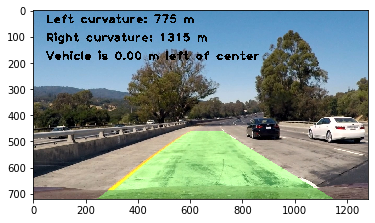

In [5]:
def image_pipeline(image):
    img_pro=img_process(image)
    leftx, lefty, rightx, righty=find_lane_pixels_all(img_pro)
    left_fit,right_fit=fit_poly(leftx, lefty, rightx, righty)
    output=drawLine(image,left_fit,right_fit)
    left_curverad, right_curverad,deviation=measure_curvature_real(left_fit,right_fit)
    output=drawInfo(output,left_curverad, right_curverad,deviation)
    return output

#test
test_image=mpimg.imread('test_images/test1.jpg')
plt.imshow(image_pipeline(test_image))   
    

## Pipeline for video

In [7]:
  
    

from moviepy.editor import VideoFileClip
        
def videoPipeline(inputVideo, outputVideo):
    """
    Process the `inputVideo` frame by frame to find the lane lines, draw curvarute and vehicle position information and
    generate `outputVideo`
    """
    myclip = VideoFileClip(inputVideo)
    clip = myclip.fl_image(image_pipeline)
    clip.write_videofile(outputVideo, audio=False)
    
# Project video
videoPipeline('project_video.mp4', 'video_output/project_video.mp4')

[MoviePy] >>>> Building video video_output/project_video.mp4
[MoviePy] Writing video video_output/project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [07:21<00:00,  2.85it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video_output/project_video.mp4 

